# Gibbs Sampling
One MCMC technique suitable for inference in Bayesian models.

The underlying logic of MCMC sampling is that we can estimate any desired expectation by ergodic averages. That is, we can compute any statistic of a posterior distribution as long as we have $N$ simulated samples from that distribution:
$$
E[f(x)]_\mathcal{P} = \frac{1}{N}\sum_{i=1}^N f(s^{(i)}),
$$
where $\mathcal{P}$ is the posterior distribution of interest, $f(s)$ the desired expectation, and $f(s^{(i)})$ the $i^{\mathrm{th}}$ simulated sample from $\mathcal{P}$.

The idea in Gibbs sampling is to generate posterior samples by sweeping through each variable (or block of variables) to sample from its conditional distribution with the remaining variables fixed to their current values.

**Algorithm 1** Generic Gibbs sampler

Initialize $x^{(0)} \sim q(x)$, where $q(x)$ is the prior distribution<br>
**for** iteration $i=1, 2, \ldots$ **do**<br>
<p style="padding-left: 2em;">$x_1^{(i)} \sim p(X_1 = x_1 | X_2 = x_2^{(i-1)}, X_3=x_3^{(i-1)},\ldots,X_D = x_D^{(i-1)})$</p>
<p style="padding-left: 2em;">$x_2^{(i)} \sim p(X_2 = x_2 | X_1 = x_1^{(i)}, X_3=x_3^{(i-1)},\ldots,X_D = x_D^{(i-1)})$</p>
<p style="padding-left: 2em;">$\vdots$</p>
<p style="padding-left: 2em;">$x_D^{(i)} \sim p(X_D = x_D | X_1 = x_1^{(i)}, X_2=x_2^{(i)},\ldots,X_{D-1} = x_{D-1}^{(i)})$</p>

**end for**  

#### The theory of MCMC guarantees that the stationary distribution of the samples generated under Algorithm 1 is the target joint posterior we are interested in. 

## Example: Gibbs sampling for Bayesian linear regression
This example comes from the [blog article by Kieran Campbell](!https://kieranrcampbell.github.io/blog/2016/05/15/gibbs-sampling-bayesian-linear-regression.html). It's always to do it yourself to make sure you fully understand what's it all about.

### Bayesian linear regression
We are interested in Gibbs sampling for normal linear regression with one independent variable. We assume we have paired data $(y_i, x_i), i=1,\ldots,N$. We wish to find the posterior distribution of the coefficients $\beta_0$ (the intercept), $\beta_1$ (the gradient) and of the precision $\tau$, which is the reciprocal of the variance. The model can be written as

$$
y_i\sim \mathcal{N}(\beta_0 + \beta_1x_i, 1/\tau),
$$

or equivalently
$$
y_i = \beta_0 + \beta_1 x_i + \epsilon, \epsilon\sim\mathcal{N}(0, 1\tau).
$$

The likelihood for this model may be written as the product over $N$ iid observations
$$
L(y_1,\ldots,y_N,x_1,\ldots,x_N|\beta_0, \beta_1, \tau) = \prod_{i=1}^N\mathcal{N}(\beta_0 + \beta_1 x_i, 1/\tau).
$$

We also wish to place **conjugate priors** on $\beta_0, \beta_1$ and $\tau$, we've discussed the reasons in the article on Dirichlet distribution. For these we choose:<br>
$$\beta_0 \sim \mathcal{N}(\mu_0, 1/\tau_0)$$<br>
$$\beta_1 \sim \mathcal{N}(\mu_1, 1/\tau_1)$$<br>
$$\tau\sim \mathrm{Gamma}(\alpha, \beta)$$<br>

### Gibbs sampling
Suppose we have two parameters $\theta_1$ and $\theta_2$ and some data $x$. Our goal is to find the posterior distribution of $p(\theta_1, \theta_2 || x)$/ To do this in a Gibbs sampling regime we need to work out the conditional distributions $p(\theta_1||\theta_2,x)$ and $p(\theta_2||\theta_1, x)$. For the procedure of Gibbs sampling see above.

The massive advantage of Gibbs sampling over other MCMC methods is that no tuning parameters are required, the downside is the need for a fair bit of maths to derive the updates, which even then aren't guaranteed to exist.

### Pythonic Setup

In [18]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,5)

## Deriving a Gibbs sampler
The general approach to deriving an update for a variable is
1. Write down the posterior conditional density in log-form
2. Throw away all the terms that don't depend on the current sampling variable
3. Pretend this is the density for your variable of interest and all other variables are fixed. What distribution does the log-density remind you of?
4. That's your conditional sampling density!

### Updates for $\beta_0$
We are interested in finding

$$
p(\beta_0|\beta_1, \tau, y, x)\propto p(y, x, |\beta_0, \beta_1, \tau)p(\beta_0).
$$

Note that $p(y, x |\beta_0, \beta_1, \tau)$ is the likelihood from above and $p(\beta_0)$ is simply $N(\mu_0, 1/\tau_0)$.

If a variable $x$ follows a normal distribution with mean $\mu$ and precision $\tau$ then the log-dependence on $x$ is $-\frac{\tau}{2}(x-\mu)^2\approx -\frac{\tau}{2}x^2 + \tau\mu x$. So if we can force the log-posterior conditional probability density into a quadratic form then the coefficient of $x$ (where $x$ is the variable of interest) will be $\tau\mu$ and the coefficient of $x^2$ will be $-\tau/2$. 

Hence the log-dependence on $\beta_0$ is:

$$
-\frac{\tau_0}{2}(\beta_0 - \mu_0)^2 - \frac{\tau}{2}\sum_{i=1}^N(y_i - \beta_0- \beta_1x_i)^2
$$

This expression is quadratic in $\beta_0$, meaning the conditional sampling density for $\beta_0$ will also be normal. Dropping all the terms that don't involve $\beta_0$ takes us to

$$
-\frac{\tau_0}{2}\beta_0^2 + \tau_0\mu_0\beta_0 - \frac{\tau}{2}N\beta_0^2 + \tau\sum_{i}(y_i-\beta_1x_i)\beta_0.
$$

In other words, the coefficient of $\beta_0$ is $\tau_0\mu_0 + \tau\sum_i(y_i-\beta_1x_i)$ while the coefficient of $\beta_0^2$ is $-\frac{\tau_0}{2} - \frac{\tau}{2}N$. This implies the conditional sampling distribution of $\beta_0$ is

$$
\beta_0|\beta_1, \tau, \tau_0, \mu_0, x, y\sim \mathcal{N}\left(\frac{\tau_0\mu_0 + \tau\sum_i(y_i-\beta_1x_i)}{\tau_0 + \tau N}, 1/(\tau_0 + \tau N)\right)
$$

Let's turn this into a Python function:

In [4]:
def sample_beta_0(y, x, beta_1, tau, mu_0, tau_0):
    N = len(y)
    assert len(x) == N
    precision = tau_0 + tau * N
    mean = tau_0 * mu_0 + tau * np.sum(y - beta_1 * x)
    mean /= precision
    return np.random.normal(mean, 1 / np.sqrt(precision))

### Update for $\beta_1$
Similarly to $\beta_0$, the dependence of the conditional log-posterior is given by 

$$
\frac{\tau_1}{2}(\beta_1 - \mu_1)^2 - \frac{\tau}{2}\sum_{i=1}^N(y_i - \beta_0 - \beta_1 x_i)^2
$$

which if we expand out and drop all terms that don't include $\beta_1$ we get

$$
-\frac{\tau_1}{2}\beta_1^2 + \tau_1\mu_1\beta_1 -\frac{\tau}{2}\sum_i x_i^2\beta_1^2 + \tau\sum_i(y_i-\beta_0)x_i\beta_1,
$$
so the coefficient of $\beta_1$ is $\tau_1\mu_1 + \tau\sum_i(y_i-\beta_0)x_i$ while the coefficient of $\beta_1^2$ is $-\frac{\tau_1}{2}-\frac{\tau}{2}\sum_i x_i^2$. Therefore the conditional sampling density of $\beta_1$ is

$$
\beta_1|\beta_0, \tau, \mu_1, \tau_1, x, y\sim \mathcal{N}\left(\frac{\tau_1\mu_1 + \tau\sum_i(y_i-\beta_0)x_i}{\tau_1 + \tau\sum_ix_i^2}, 1/(\tau_1 + \tau\sum_i x_i^2)\right)
$$

In [5]:
def sample_beta_1(y, x, beta_0, tau, mu_1, tau_1):
    N = len(y)
    assert len(x) == N
    precision = tau_1 + tau * np.sum(x * x)
    mean = tau_1 * mu_1 + tau * np.sum((y - beta_0) * x)
    mean /= precision
    return np.random.normal(mean, 1/np.sqrt(precision))

### Update for $\tau$
Deriving the Gibbs update for $\tau$ is the trickiest part as we have to deal with non-Gaussian distribution. 

First introduce the Gamma distribution, parameterised by $\alpha$ and $\beta$. Up to the normalising constant the probability of an observation $x$ under a Gamma density is given by:

$$
p(x; \alpha, \beta) \propto \beta^\alpha x^{\alpha-1}e^{-\beta x},
$$

so the log-dependency of any terms involving $x$ is given by

$$
l(x; \alpha, \beta) \propto (\alpha - 1)\log x - \beta x.
$$

We want

$$
p(\tau|\beta_0, \beta_1, y, x) \propto p(y, x, |\beta_0, \beta_1, \tau)p(\tau)
$$

which in this case is a density of

$$
\prod_{i=1}^N\mathcal{N}(y_i|\beta_0 + \beta_1 x_i, 1/\tau) \times \mathrm{Gamma}(\tau | \alpha,\beta).
$$

Key question: *what is the density of $\tau$ assuming all other parameters are held constant?* If we look at the log density of this expression we get:

$$
\frac{N}{2}\log\tau - \frac{\tau}{2}\sum_i(y_i - \beta_0 - \beta_1 x_i)^2 + (\alpha-1)\log\tau - \beta\tau,
$$

which has a coefficient of $\tau$ of $-\sum_i\frac{(y_i-\beta_0-\beta_1x_i)^2}{2} - \beta$ and a coefficient of $\log\tau$ of $\frac{N}{2}+\alpha - 1$. If you look at the equation of the log-density of the Gamma distribution above, this implies that $\tau$ has a conditional sampling density of

$$
\tau |\beta_0, \beta_1, \alpha, \beta, x, y\sim \mathrm{Gamma}\left(\alpha + \frac{N}{2}, \beta + \sum_i\frac{(y_i - \beta_0 - \beta_1x_i)^2}{2}\right)
$$

We can now code this into Python. `np.random.gamma` uses the shape and scale parameterization of a Gamma distribution, where she shape $k = \alpha$ but the scale $\theta = 1/\beta$, so we need to invert our expression for $\beta$ before sampling:

In [6]:
def sample_tau(y, x, beta_0, beta_1, alpha, beta):
    N = len(y)
    alpha_new = alpha + N / 2
    resid = y - beta_0 - beta_1 * x
    beta_new = beta + np.sum(resid * resid) / 2
    return np.random.gamma(alpha_new, 1 / beta_new)

### Some synthetic data
To test we need some synthetic data. Let's set $\beta_0 = -1$, $\beta_1 = 2$ and $\tau = 1$.

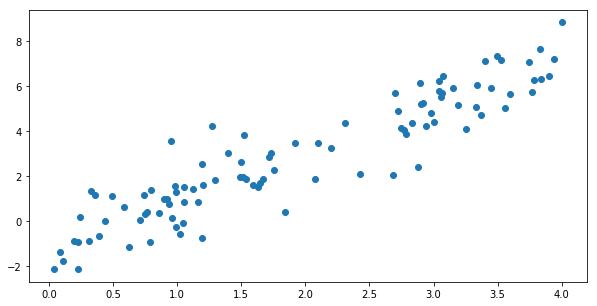

In [25]:
beta_0_true = -1
beta_1_true = 2
tau_true = 1

N = 100
x = np.random.uniform(low=0, high=4, size=N)
y = np.random.normal(beta_0_true + beta_1_true * x, 1 / np. sqrt(tau_true))

synth_plot = plt.plot(x, y, 'o')

## Write our Gibbs sampler
Apart from the data we need to supply initial parameter estimates and hyper parameters. We can place $\mathcal{N}(0, 1)$ priors on $\beta_0$ and $\beta_1$ and a $\mathrm{Gamma}(2,1)$ prior on $\tau$. It then makes sense to initialize the sampler at the maximum likelihood estimates of the priors.

In [26]:
init = {'beta_0': 0,
       'beta_1': 0,
       'tau': 2}

## Specify hyper parameters
hypers = {'mu_0': 0,
          'tau_0': 1,
          'mu_1': 0, 
         'tau_1': 1,
         'alpha': 2,
         'beta': 1}

In [27]:
def gibbs(y, x, iters, init, hypers):
    assert len(y) == len(x)
    beta_0 = init['beta_0']
    beta_1 = init['beta_1']
    tau = init['tau']
    
    trace = np.zeros((iters, 3)) # Trace to store values of beta_0, beta_1, tau
    for it in range(iters):
        beta_0 = sample_beta_0(y, x, beta_1, tau, hypers['mu_0'], hypers['tau_0'])
        beta_1 = sample_beta_1(y, x, beta_0, tau, hypers['mu_1'], hypers['tau_1'])
        tau = sample_tau(y, x, beta_0, beta_1, hypers['alpha'], hypers['beta'])
        trace[it,:] = np.array((beta_0, beta_1, tau))
        
    trace = pd.DataFrame(trace)
    trace.columns = ['beta_0', 'beta_1', 'tau']
    
    return trace

In [32]:
iters = 10000
trace = gibbs(y, x, iters, init, hypers)

Plot the traces for the three variables. Inspecting trace plots for convergence is a bit of a dark art in MCMC inferences. Over the first few (or in the case of Metropolis-Hastings, many) iterations you expect the values to change quite significantly. Then they should reach some equilibrium distribution which will be the posterior distribution of that variable.

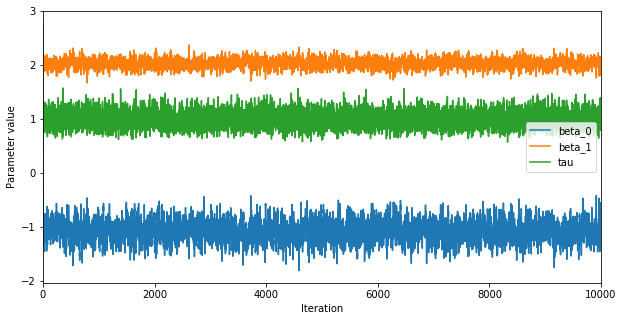

In [33]:
traceplot = trace.plot()
traceplot.set_xlabel('Iteration')
traceplot.set_ylabel('Parameter value');

We can see that over the first 20 or so iterations the values change significantly before going to some constant value of around $\beta_0=-1$, $\beta_1=2$ and $\tau=1$. Even if it's obvious that the variables converge early it is convention to define a 'burn-in' period where we assume the parameters are still converting, which is typically half of the iterations. Therefore we can define a new `DataFrame` that contains the final 500 iterations called `trace_burnt`, and plot histograms of the values

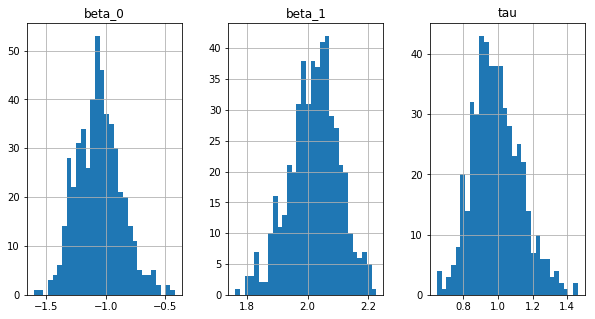

In [34]:
trace_burnt = trace[-500:]
hist_plot = trace_burnt.hist(bins=30, layout=(1, 3))

In [35]:
print(trace_burnt.median())
print(trace_burnt.std())

beta_0   -1.060638
beta_1    2.026371
tau       0.981942
dtype: float64
beta_0    0.186160
beta_1    0.082226
tau       0.138661
dtype: float64


We see that the posterior median always fall within at most one standard deviation of the true value.

So here we have a Gibbs sampler for Bayesian linear regression in Python. Other topics to cover include
- Thinning observations in MCMC runs
- Alternative model specifications, e.g. Automatic Relevance Determination (ARD) priors
- Blocked Gibbs samplers
- Collapsed Gibbs samplers